In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

## Abstract:

In this Blog Post, we implement logistic regression. We will run three experiments to understand the working of logistic regression. In the first experiment, we will implement logistic regression using vanilla gradient descent. In the second experiment, we will implement logistic regression using gradient descent with momentum. In the third experiment, we will examine the issues of overfitting. We find that when $\beta$ is higher (momentum), the model converges faster. We also find that the model overfits when the the number of features is larger than the normal of observations

In this blog post we will:

1. Implement gradient descent for logistic regression in an object-oriented paradigm.
2. Implement a key variant of gradient descent with momentum in order to achieve faster convergence.
3. Perform experiments to test our implementations.

## Part A: Implement Logistic Regression

To view my implementation of logistic regression, please refer to [logistic.py](./logistic.py)



## Part B: Experiments

# Generating Data 

We will use the following code to generate data for a classification problem.

The number of points is controlled by `n_points` 

The number of features is controlled by adjusting `p_dims` 

The difficulty of the problem is controlled by adjusting `noise` (higher noise means harder problem)

We will also visualize this code in a plot to see how the data looks.

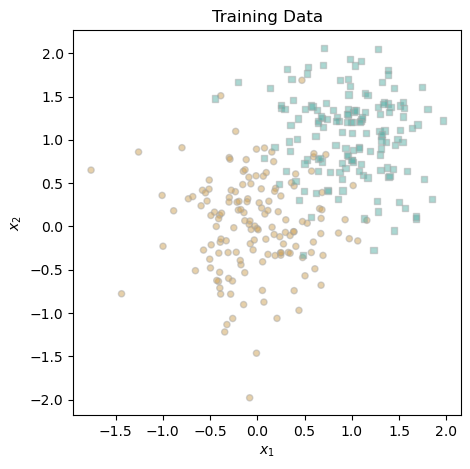

In [2]:
import torch
from matplotlib import pyplot as plt

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -0.5, vmax = 1.5, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1234)

# plot data
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
ax.set_title("Training Data");

# Experiment 1: Vanilla Gradient Descent

To begin, we will use the following code to train a logistic regression model using vanilla gradient descent.

In the code below, by setting $\beta = 0$ we are effectively using vanilla gradient descent.

In [16]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

while len(loss_vec) < 2 or loss_vec[-2] - loss_vec[-1] > 0.00001:
    opt.step(X, y, alpha = 0.001, beta = 0)

    # calculate and record loss
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

Now that the model is trained, we will plot the decision boundary and the data points.

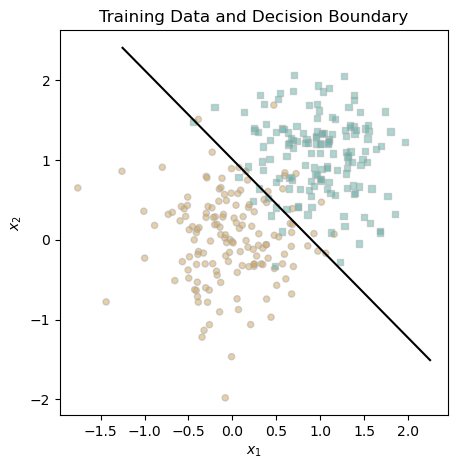

In [12]:
# define function to draw line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# plot decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
draw_line(LR.w, x_min = -1.25, x_max = 2.25, ax = ax, color = "black")
ax.set_title("Training Data and Decision Boundary");

The decision boundary is not perfect, but it does a good job of separating the two classes. This is a good sign that our model has learned the underlying pattern in the data. Let's next visualize the loss function over the course of training.

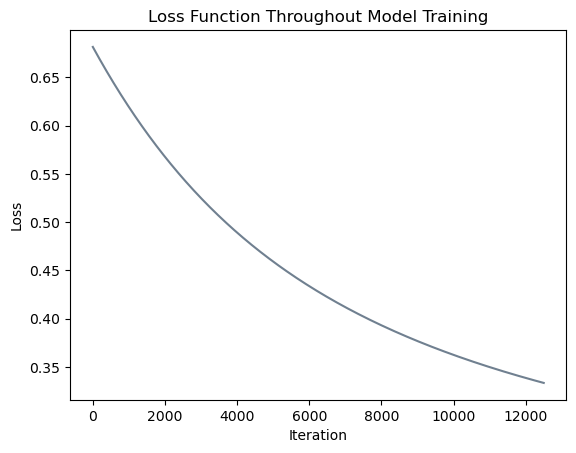

In [17]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

In the plot, our loss function decreases with each iteration. This behavior is expected, as gradient descent is designed to minimize the loss function.

# Experiment 2: Gradient Descent with Momentum

Next, we will use the following code to train a logistic regression model using gradient descent with momentum. Using momentum, we can achieve faster convergence and potentially better performance.

For our test, we will set $\beta = 0.9$.

In [18]:
# set seed
torch.manual_seed(1234)
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize vector to record loss values
loss_vec_momentum = []

# fit model
while len(loss_vec_momentum) < 2 or loss_vec_momentum[-2] - loss_vec_momentum[-1] > 0.00001:
    opt.step(X, y, alpha = 0.001, beta = 0.9)

    loss = LR.loss(X, y) 
    loss_vec_momentum.append(loss)

After training the model, we will use the same plot as before to visualize the loss function over the course of training.

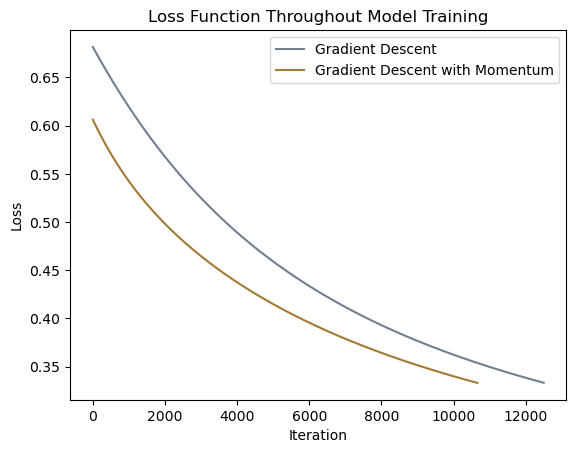

In [19]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey", label = "Gradient Descent")
plt.plot(loss_vec_momentum, color = "#A37933", label = "Gradient Descent with Momentum")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training")
plt.legend();


In this case, we see that the loss function decreases more rapidly than in our model with momentum than the model without momentum albeit rather slightly. Although this is seemingly a small difference, over many iterations, this can lead to significant improvements in convergence time.

# Experiment 3: Overfitting

In this experiment we will generate some data where `p_dim` > `n_points`. We will do this twice with the same exact parameters.

We will then call the firsy dayaset `X_train`, `y_train` and the second dataset `X_test`, `y_test`.

We will experiment in which we fit a logistic regression model to the training data and evaluate its performance on the test data.

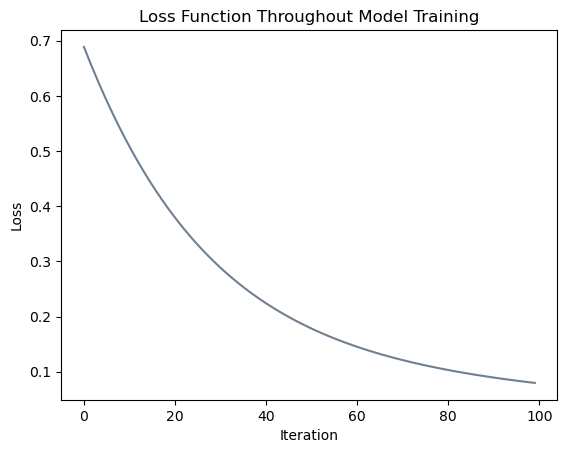

In [21]:
# set seed
torch.manual_seed(1234)

# generate data
X_train, y_train = classification_data(n_points = 20, noise = 0.5, p_dims = 30)
X_test, y_test = classification_data(n_points = 20, noise = 0.5, p_dims = 30)

# initialize logistic regression model and optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# initialize vector to record loss values
loss_vec_over = []

# fit model
for _ in range(100):
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)

    # calculate and record loss
    loss = LR.loss(X_train, y_train) 
    loss_vec_over.append(loss)
    if loss == 0:
        break

# plot the changes in loss 
plt.plot(loss_vec_over, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

As before, through the plot we can see that the loss function decreases with each iteration. Let's check the accuracy!

In [17]:
y_hat = LR.predict(X_train)
train_accuracy = (1.0*(y_hat == y_train)).mean().item()
train_accuracy

1.0

We have a training accuracy of 100%. Our model is correctly predicting all the training data points. That being said, let's now check our model against the testing data.

In [18]:
y_hat = LR.predict(X_test)
test_accuracy = (1.0*(y_hat == y_test)).mean().item()
test_accuracy

0.6499999761581421

After testing our model on our testing data, we only achieve an accuracy nearing 65%. The reason being due to our model overfitting the training data. This is a common problem when the number of features is greater than the number of data points. 

## Conclusion 

In this blog post, we implemented logistic regression in an object-oriented paradigm and tested our implementation with various experiments. We trained a logistic regression model using vanilla gradient descent and gradient descent with momentum. We also explored the concept of overfitting by generating data where the number of features is greater than the number of data points. Through these experiments, I gained a better understanding of logistic regression and gradient descent optimization techniques.